<a href="https://colab.research.google.com/github/AugustoAnguita/Bioinformatics_UB/blob/main/SESION%204_5/sesion_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ESTRATEGIAS DE VALIDACIÓN: APRENDIZAJE DE CÁNCER DE MAMA MEDIANTE IMÁGENES**  




En esta práctica aprenderemos a realizar diferentes **técnicas de particionado de datos**:

- *Hold-out*

- *Validación cruzada k-fold*

- *Repeated k-fold*

- *Validación cruzada estratificada*

- *Leave-One-Out (LOO)*

Usaremos el conjunto de datos *Breast Cancer* incluido en la librería mlbench, equivalente al dataset de Scikit-learn en Python.

# **Recordatorio: Introducción al NoteBook**
Dentro de este cuaderno (NoteBook), se te guiará paso a paso desde la carga de un conjunto de datos hasta la realización del análisis de su contenido.

El cuaderno *Jupyter* (Python) es un enfoque que combina bloques de texto (como este) junto con bloques o celdas de código. La gran ventaja de este tipo de celda es su interactividad, ya que pueden ejecutarse para comprobar los resultados directamente en ellas. *Muy importante:* **el orden de las instrucciones es fundamental**, por lo que cada celda de este cuaderno debe ejecutarse secuencialmente. Si se omite alguna, el programa puede dar un error, así que, en caso de duda, debes comenzar desde el principio.

Antes que nada:

Es **muy muy importante** que al inicio selecciones **"*Open in draft mode*" (draft mode)** (modo borrador), en la parte superior izquierda. De lo contrario, no te permitirá ejecutar ningún bloque de código, por motivos de seguridad. Cuando se ejecute el primero de los bloques aparecerá el siguiente mensaje: "*Warning: This notebook was not created by Google.*". No te preocupes, debes confiar en el contenido del cuaderno (NoteBook) y hacer clic en "Run anyway".

¡Vamos allá!

Haz clic en el botón "play" situado a la izquierda de cada celda de código. Las líneas de código que comienzan con una almohadilla (#) son comentarios y no afectan a la ejecución del programa.

También puedes hacer clic en cada celda y presionar "*ctrl+enter*" (*cmd+enter* on Mac).

Cada vez que ejecutes un bloque, verás la salida justo debajo. La información suele estar siempre relacionada con la última instrucción, junto con todos los comandos `print()` que aparezcan en el código.




## **INDICE**
1. [Instalación del Entorno R y Librerías](#install-libraries)    
2. [Carga y preparación de datos](#load-data)
3. [Validación Hold-Out](#3)   
4. [Validación Cruzada k-Fold](#4)   
5. [Repeated k-Fold (k-fold repetido)](#5)
6. [Validación Cruzada Estratificada](#6)   
7. [Validación Leave-One-Out (LOO)](#7)   
8. [Resumen y comparación de técnicas](#8)      


## **1. Instalación del Entorno R y Librerías** <a name="install-libraries"></a>

A continuación, instalamos/cargamos las librerías necesarias para esta sesión. En el contexto del análisis del exposoma, las librerías de R nos ofrecen una forma mucho más conveniente de procesar, manipular y analizar los datos. Algunas de estas librerías: `tidyverse`, `skimr`, `readr`.

La instalación de R en nuestro entorno de Google Colab se llevará a cabo en el siguiente bloque de código. Debe recordarse que todas las instalaciones de librerías que realicemos en el entorno de Google Colab permanecerán activas solo durante unas horas, tras lo cual las librerías instaladas se eliminan. Por lo tanto, será necesario volver a ejecutar el código de instalación de librerías de esta sección siempre que se necesite volver a correr el cuaderno después de este tiempo.

Nota: Recomendamos instalar las librerías 5 minutos antes del inicio de la sesión❗❗❗


In [1]:
# first we check the R version we have
R.Version()

$platform
[1] "x86_64-pc-linux-gnu"

$arch
[1] "x86_64"

$os
[1] "linux-gnu"

$system
[1] "x86_64, linux-gnu"

$status
[1] ""

$major
[1] "4"

$minor
[1] "5.1"

$year
[1] "2025"

$month
[1] "06"

$day
[1] "13"

$`svn rev`
[1] "88306"

$language
[1] "R"

$version.string
[1] "R version 4.5.1 (2025-06-13)"

$nickname
[1] "Great Square Root"

* **Instalar/cargar librerías para la sesión**

Vamos a instalar/cargar las librerías necesarias para la sesión práctica.
Para ello, utilizaremos el paquete `pacman`, que es una herramienta de gestión que combina las funcionalidades de las funciones `install.packages` + `library`.

In [2]:
# Estimated execution time: 3 seconds approx.

install.packages('pacman') # allows us to install/upload packages simultaneously

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Instalaremos `BiocManager` y `rexposome` (estos dos paquetes son esenciales para el análisis del exposoma) utilizando el siguiente código, ya que a veces existen problemas de compatibilidad con la versión de R.

El proceso puede tardar **unos minutos**, por lo que se recomienda realizar la instalación durante la sesión teórica.


In [12]:
# Estimated execution time: 1 minute approx.

if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")

packages = c("tidyverse","rsample","mlbench","ggplot2"
)
for( pkg in packages ) {
  if( !pkg %in% rownames( installed.packages() ) ) {
    message( "Installing ", pkg )
    BiocManager::install( pkg )
  }
}

In [13]:
# Estimated execution time: 1 minute approx.
# Add all the libraries we need to use (if the package is already installed, it will automatically load the package if it is in the pacman::p_load() function).
pacman::p_load(tidyverse,rsample,mlbench,ggplot2)

## **2. Carga y preparación de datos** <a name="load-data"></a>

A continuación encontramos las **líneas de código** necesarias para **cargar** el dataset de cancer de mama.

**1.-** Carga de datos (los datos estan disponibles dentro del paquete `mlbench`).

In [22]:
data(BreastCancer, package = "mlbench")
df <- as_tibble(BreastCancer)

In [24]:
## Limpieza mínima: quitar ID, convertir predictores a numérico, eliminar NA
df <- df %>%
  mutate(idx = row_number()) %>%     # índice para rastrear particiones (equivalente a .index en Python)
  select(-Id) %>%
  mutate(across(-c(Class, idx), ~ as.numeric(.))) %>%
  drop_na()


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(everything(), ~as.numeric(as.character(.)))`.
Caused by warning:
! NAs introduced by coercion”


**2.-** Podemos consultar su estructura y dimensiones

In [8]:
dplyr::glimpse(df) # Tenemos 500 individuos y 14 variables

head(df)

Rows: 683
Columns: 11
$ Cl.thickness    <dbl> 5, 5, 3, 6, 4, 8, 1, 2, 2, 4, 1, 2, 5, 1, 8, 7, 4, 4, …
$ Cell.size       <dbl> 1, 4, 1, 8, 1, 10, 1, 1, 1, 2, 1, 1, 3, 1, 7, 4, 1, 1,…
$ Cell.shape      <dbl> 1, 4, 1, 8, 1, 10, 1, 2, 1, 1, 1, 1, 3, 1, 5, 6, 1, 1,…
$ Marg.adhesion   <dbl> 1, 5, 1, 1, 3, 8, 1, 1, 1, 1, 1, 1, 3, 1, 10, 4, 1, 1,…
$ Epith.c.size    <dbl> 2, 7, 2, 3, 2, 7, 2, 2, 2, 2, 1, 2, 2, 2, 7, 6, 2, 2, …
$ Bare.nuclei     <dbl> 1, 10, 2, 4, 1, 10, 10, 1, 1, 1, 1, 1, 3, 3, 9, 1, 1, …
$ Bl.cromatin     <dbl> 3, 3, 3, 3, 3, 9, 3, 3, 1, 2, 3, 2, 4, 3, 5, 4, 2, 3, …
$ Normal.nucleoli <dbl> 1, 2, 1, 7, 1, 7, 1, 1, 1, 1, 1, 1, 4, 1, 5, 3, 1, 1, …
$ Mitoses         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 4, 1, 1, 1, …
$ Class           <fct> benign, benign, benign, benign, benign, malignant, ben…
$ idx             <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…


Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class,idx
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
5,1,1,1,2,1,3,1,1,benign,1
5,4,4,5,7,10,3,2,1,benign,2
3,1,1,1,2,2,3,1,1,benign,3
6,8,8,1,3,4,3,7,1,benign,4
4,1,1,3,2,1,3,1,1,benign,5
8,10,10,8,7,10,9,7,1,malignant,6


**3.-** Como hemos explicado en clase, es importante conocer si existe un desbalanceo importante entre clases a la hora de elegir la estrategia de validación (por ejemplo, si tuvieramos muy pocos sujetos en la clase "malignant" podríamos elegir una validación cruzada estratificada)

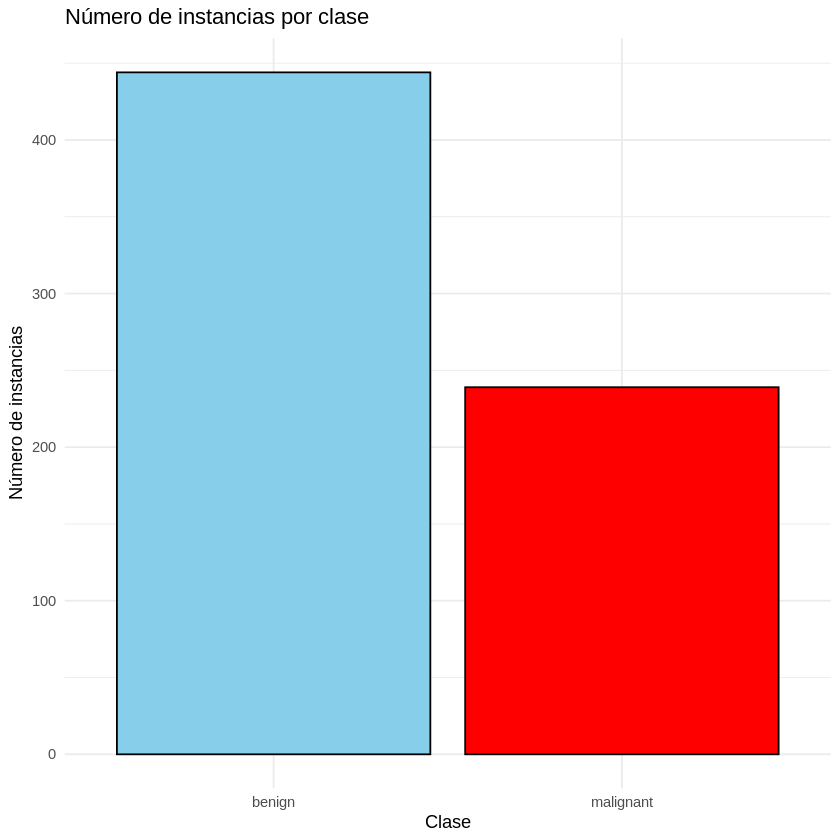

In [16]:
# Contar y graficar
ggplot(df, aes(x = Class)) +
  geom_bar(fill = c("skyblue","red"), color = "black") +
  labs(title = "Número de instancias por clase",
       x = "Clase",
       y = "Número de instancias") +
  theme_minimal()

In [19]:
## Separar X (entrada) e y (salida)
X <- df %>% select(-Class)
y <- df %>% select(Class)
class(X)
class(y)

[1] "tbl_df"     "tbl"        "data.frame"

[1] "tbl_df"     "tbl"        "data.frame"

A partir del código anterior, se puede extraer la siguiente información:
- `X` e `y` son dos estructuras de datos tipo `dataframe` (marco de datos). Un `dataframe` se entiende como un vector n-dimensional`.  

- `X` contiene la matriz de datos de entrada e `y` es un vector unidimensional con la etiqueta de cada muestra en `X`. Por simplicidad, en este caso se ha optado por resolver un problema de clasificación (variable de salida de tipo categórica).

- En el aprendizaje de tipo supervisado, `X` e `y` se usarán para construir el modelo de Machine Learning y probarlo.


### **3. Validación Hold-Out** <a name="3"></a>



En R, el método **hold-out** consiste en dividir el conjunto de datos original en dos subconjuntos disjuntos:  
- Un conjunto de **entrenamiento** para ajustar el modelo.  
- Un conjunto de **prueba** para evaluar su rendimiento.

La proporción se controla con el parámetro `prop` de la función `initial_split()` del paquete **rsample**.  
Valores típicos: **0.6, 0.75 u 0.8** para entrenamiento (y el resto para test).

**Ventajas:**
- Muy rápido y fácil de implementar.
- Útil para pruebas preliminares y para modelos que se entrenan de forma costosa.

**Limitaciones:**
- Sensible a cómo se dividan los datos: si el subconjunto de test contiene observaciones más difíciles, la estimación del rendimiento puede ser muy pesimista.
- La división aleatoria implica que distintos *splits* pueden dar resultados muy diferentes.  
  Por eso, **siempre fijamos una semilla con `set.seed()`** para reproducir los mismos resultados.

⚠️ Es importante comprobar que **ninguna observación de test** aparezca en el conjunto de entrenamiento.  

In [26]:
set.seed(42)   # reproducibilidad
ratio <- 0.2   # 20% para test

# Hold-out estratificado por clase
split_ho <- initial_split(df, prop = 1 - ratio, strata = "Class")

train_df <- training(split_ho)
test_df  <- testing(split_ho)

cat("Tamaño entrenamiento:", nrow(train_df), "\n")
cat("Tamaño test:", nrow(test_df), "\n")

# Verificar disjunción de instancias
solapan <- length(intersect(train_df$idx, test_df$idx)) > 0
cat("¿Hay solapamiento entre train y test? ->", solapan, "\n")

# Distribución de clases (opcional)
cat("\nDistribución de clases:\n")
print(table(train_df$Class))
print(table(test_df$Class))


Tamaño entrenamiento: 558 
Tamaño test: 141 


Warning message:
“Unknown or uninitialised column: `idx`.”


¿Hay solapamiento entre train y test? -> FALSE 

Distribución de clases:

   benign malignant 
      366       192 

   benign malignant 
       92        49 


### **4 .Validación Cruzada k-Fold**  <a name="4"></a>

La **validación cruzada k-fold** es el estándar en aprendizaje supervisado:

- Divide los datos en **k particiones del mismo tamaño (o casi)**.

**Entrena k veces**, usando cada fold como test una única vez y el resto como train.

- **Permite usar todos los datos para entrenar y validar**, con una estimación del rendimiento mucho más estable que hold-out.

En R con rsample usamos `vfold_cv()`:

**Por defecto NO estratifica; si queremos estratificación (clasificación), usaremos strata = "Class" (lo veremos en la siguiente sección).**

- Aquí primero mostramos el k-fold no estratificado, que emula KFold puro.

- Imprimiremos para cada fold:

  - Tamaño de train/test.

  - Distribución de clases (para ver que puede variar si no estratificamos).

  - Algunos índices de ejemplo (usamos la columna idx que creamos al principio).



In [ ]:
set.seed(42)
k <- 5

cv_kf <- vfold_cv(df, v = k)  # NO estratificado

cat("K-Fold (no estratificado):\n")
for (i in seq_len(nrow(cv_kf))) {
  tr <- analysis(cv_kf$splits[[i]])
  te <- assessment(cv_kf$splits[[i]])

  cat(sprintf("\nFold %d\n", i))
  cat("  Tamaño train/test:", nrow(tr), "/", nrow(te), "\n")
  cat("  Clases en train: "); print(table(tr$Class))
  cat("  Clases en test : "); print(table(te$Class))
  cat("  Índices ejemplo (train head): ", paste(head(sort(tr$idx), 8), collapse=", "), "\n")
  cat("  Índices ejemplo (test  head): ", paste(head(sort(te$idx), 8), collapse=", "), "\n")
}

### **5. Repeated k-Fold (k-fold repetido)** <a name="5"></a>

Para **reducir la dependencia de una única partición k-fold**, se puede **repetir el proceso varias veces**.

En rsample, basta con vfold_cv(..., repeats = R).

Elecciones típicas: k = 5 o 10 y repeats = 3 (si los datos lo permiten).

Esto añade **robustez estadística y reduce la varianza de la estimación del rendimiento**. **Es especialmente recomendado para Ns bajas**.

In [28]:
set.seed(42)
k <- 5
reps <- 3

cv_rkf <- vfold_cv(df, v = k, repeats = reps)  # repetido, no estratificado

cat("Repeated K-Fold (no estratificado):\n")
for (i in seq_len(nrow(cv_rkf))) {
  tr <- analysis(cv_rkf$splits[[i]])
  te <- assessment(cv_rkf$splits[[i]])

  # Mostrar comienzo de cada repetición
  if ((i - 1) %% k == 0) cat(sprintf("\nRepetición %d\n", (i - 1) %/% k + 1))

  cat(sprintf("  Fold %d (global %d) | train/test: %d/%d\n",
              ((i - 1) %% k) + 1, i, nrow(tr), nrow(te)))
}


Repeated K-Fold (no estratificado):

Repetición 1
  Fold 1 (global 1) | train/test: 559/140
  Fold 2 (global 2) | train/test: 559/140
  Fold 3 (global 3) | train/test: 559/140
  Fold 4 (global 4) | train/test: 559/140
  Fold 5 (global 5) | train/test: 560/139

Repetición 2
  Fold 1 (global 6) | train/test: 559/140
  Fold 2 (global 7) | train/test: 559/140
  Fold 3 (global 8) | train/test: 559/140
  Fold 4 (global 9) | train/test: 559/140
  Fold 5 (global 10) | train/test: 560/139

Repetición 3
  Fold 1 (global 11) | train/test: 559/140
  Fold 2 (global 12) | train/test: 559/140
  Fold 3 (global 13) | train/test: 559/140
  Fold 4 (global 14) | train/test: 559/140
  Fold 5 (global 15) | train/test: 560/139


### **6. Validación Cruzada Estratificada** <a name="6"></a>

Cuando la **variable objetivo esta desbalanceada** (casos >> controles), es recomendable que **cada fold mantenga la proporción de clases** del conjunto original.

En rsample, esto se consigue con `vfold_cv(..., strata = "Class")`.

Compararemos:

- k-fold estratificado (proporciones estables por fold).

- k-fold no estratificado (las proporciones pueden fluctuar, especialmente si hay desbalance).

**Esto es crucial en biomedicina: evitar sesgos por clases raras (e.g., prevalencia baja).**

In [29]:
set.seed(42)
k <- 5

# Estratificado por clase
cv_strat <- vfold_cv(df, v = k, strata = "Class")

cat("Comprobar distribución de clases en K-Fold ESTRATIFICADO:\n")
for (i in seq_len(nrow(cv_strat))) {
  te <- assessment(cv_strat$splits[[i]])
  prop <- prop.table(table(te$Class))
  cat(sprintf("  Fold %d  -> ", i)); print(round(prop, 3))
}

# No estratificado (para comparar)
cv_kf2 <- vfold_cv(df, v = k)

cat("\nComprobar distribución de clases en K-Fold NO estratificado:\n")
for (i in seq_len(nrow(cv_kf2))) {
  te <- assessment(cv_kf2$splits[[i]])
  prop <- prop.table(table(te$Class))
  cat(sprintf("  Fold %d  -> ", i)); print(round(prop, 3))
}

Comprobar distribución de clases en K-Fold ESTRATIFICADO:
  Fold 1  -> 
   benign malignant 
    0.652     0.348 
  Fold 2  -> 
   benign malignant 
    0.657     0.343 
  Fold 3  -> 
   benign malignant 
    0.657     0.343 
  Fold 4  -> 
   benign malignant 
    0.655     0.345 
  Fold 5  -> 
   benign malignant 
    0.655     0.345 

Comprobar distribución de clases en K-Fold NO estratificado:
  Fold 1  -> 
   benign malignant 
    0.621     0.379 
  Fold 2  -> 
   benign malignant 
    0.693     0.307 
  Fold 3  -> 
   benign malignant 
    0.629     0.371 
  Fold 4  -> 
   benign malignant 
    0.707     0.293 
  Fold 5  -> 
   benign malignant 
    0.626     0.374 


### **7. Validación Leave-One-Out (LOO)** <a name="7"></a>


LOO es un **caso límite del k-fold** con k = n (una observación queda para test en cada iteración):

Cada modelo se ajusta con (n − 1) muestras y se evalúa con 1 muestra.

**Coste computacional muy alto (entrenas n modelos)**.

Suele presentar **alta varianza en la estimación** (los entrenamientos son casi idénticos pero puede haber mucho cambio en la estimación).

En rsample, LOO se construye con loo_cv().
+
Mostraremos el número de particiones creadas y un ejemplo de la última partición.

In [30]:
# ¡Cuidado! LOO crea tantos splits como filas en df.
cv_loo <- loo_cv(df)

cat("Número de particiones LOO:", nrow(cv_loo), "\n")

# Tomamos la última partición como ejemplo
last_split <- cv_loo$splits[[nrow(cv_loo)]]
tr <- analysis(last_split)
te <- assessment(last_split)

cat(sprintf("Ejemplo última partición: sizeTrain[%d] sizeTest[%d]\n",
            nrow(tr), nrow(te)))
cat("Índice test:", te$idx, "\n")  # la única muestra en test

Número de particiones LOO: 699 
Ejemplo última partición: sizeTrain[698] sizeTest[1]


Warning message:
“Unknown or uninitialised column: `idx`.”


Índice test: 


### **8. Resumen y comparación de técnicas** <a name="8"></a>

**Notas y recomendaciones prácticas (R)**
- Fija semilla (`set.seed()`) antes de crear particiones para reproducibilidad.

- En clasificación, usa estratificación `(strata = "Class")` en `initial_split()` y `vfold_cv()` para mantener proporciones.

- Cuando el dataset es pequeño y/o hay desbalance de clases, prefiere k-fold (o repeated k-fold) frente a hold-out.

- LOO solo cuando el dataset es muy pequeño y el coste lo permite; ten en cuenta su alta varianza.

- Para evaluar modelos dentro de cada partición, integra el entrenamiento (p. ej., glm, rpart, randomForest, xgboost) dentro del bucle de vfold_cv y guarda métricas (accuracy, AUC, etc.) promediando sobre folds.

A continuación podemos ver una comparativa de los métodos de particionamiento.

| Método                   | Descripción                                                                                                              | Ventajas                                                        | Desventajas                                                                                      | Uso recomendado                                                           |
| ------------------------ | ------------------------------------------------------------------------------------------------------------------------ | --------------------------------------------------------------- | ------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------- |
| **Hold-out**             | Divide el dataset en dos conjuntos (train y test) con un ratio fijo (p. ej. 80%-20%).                                    | Simple, rápido y fácil de implementar.                          | Resultados muy dependientes de cómo se hace la división. Posible sesgo si la muestra es pequeña. | Pruebas rápidas, datasets grandes, estimación inicial del rendimiento.    |
| **K-Fold**               | Divide el dataset en *k* partes y entrena *k* veces, usando en cada iteración una parte para test y el resto para train. | Usa todos los datos para entrenamiento y test, reduce sesgo.    | Más coste computacional que hold-out.                                                            | Evaluaciones más rigurosas, datasets medianos o pequeños.                 |
| **Repeated K-Fold**      | Igual que K-Fold, pero repite el proceso varias veces con diferentes divisiones aleatorias.                              | Reduce el efecto de divisiones azarosas.                        | Incrementa el coste computacional.                                                               | Cuando se quiere robustez estadística y se dispone de tiempo de cómputo.  |
| **K-Fold Estratificado** | Variante de K-Fold que preserva la proporción de clases en cada fold.                                                    | Evita sesgo en clasificación con clases desbalanceadas.         | Solo aplicable a clasificación.                                                                  | Clasificación con datos desbalanceados.                                   |
| **Leave-One-Out (LOO)**  | Cada instancia se usa una vez como test y el resto como train (n modelos en total).                                      | Usa el máximo de datos posible para entrenar en cada iteración. | Muy costoso computacionalmente y alta varianza en los resultados.                                | Datasets muy pequeños donde no se quiera perder datos para entrenamiento. |
